In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_1st
cluster = cluster_1st

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

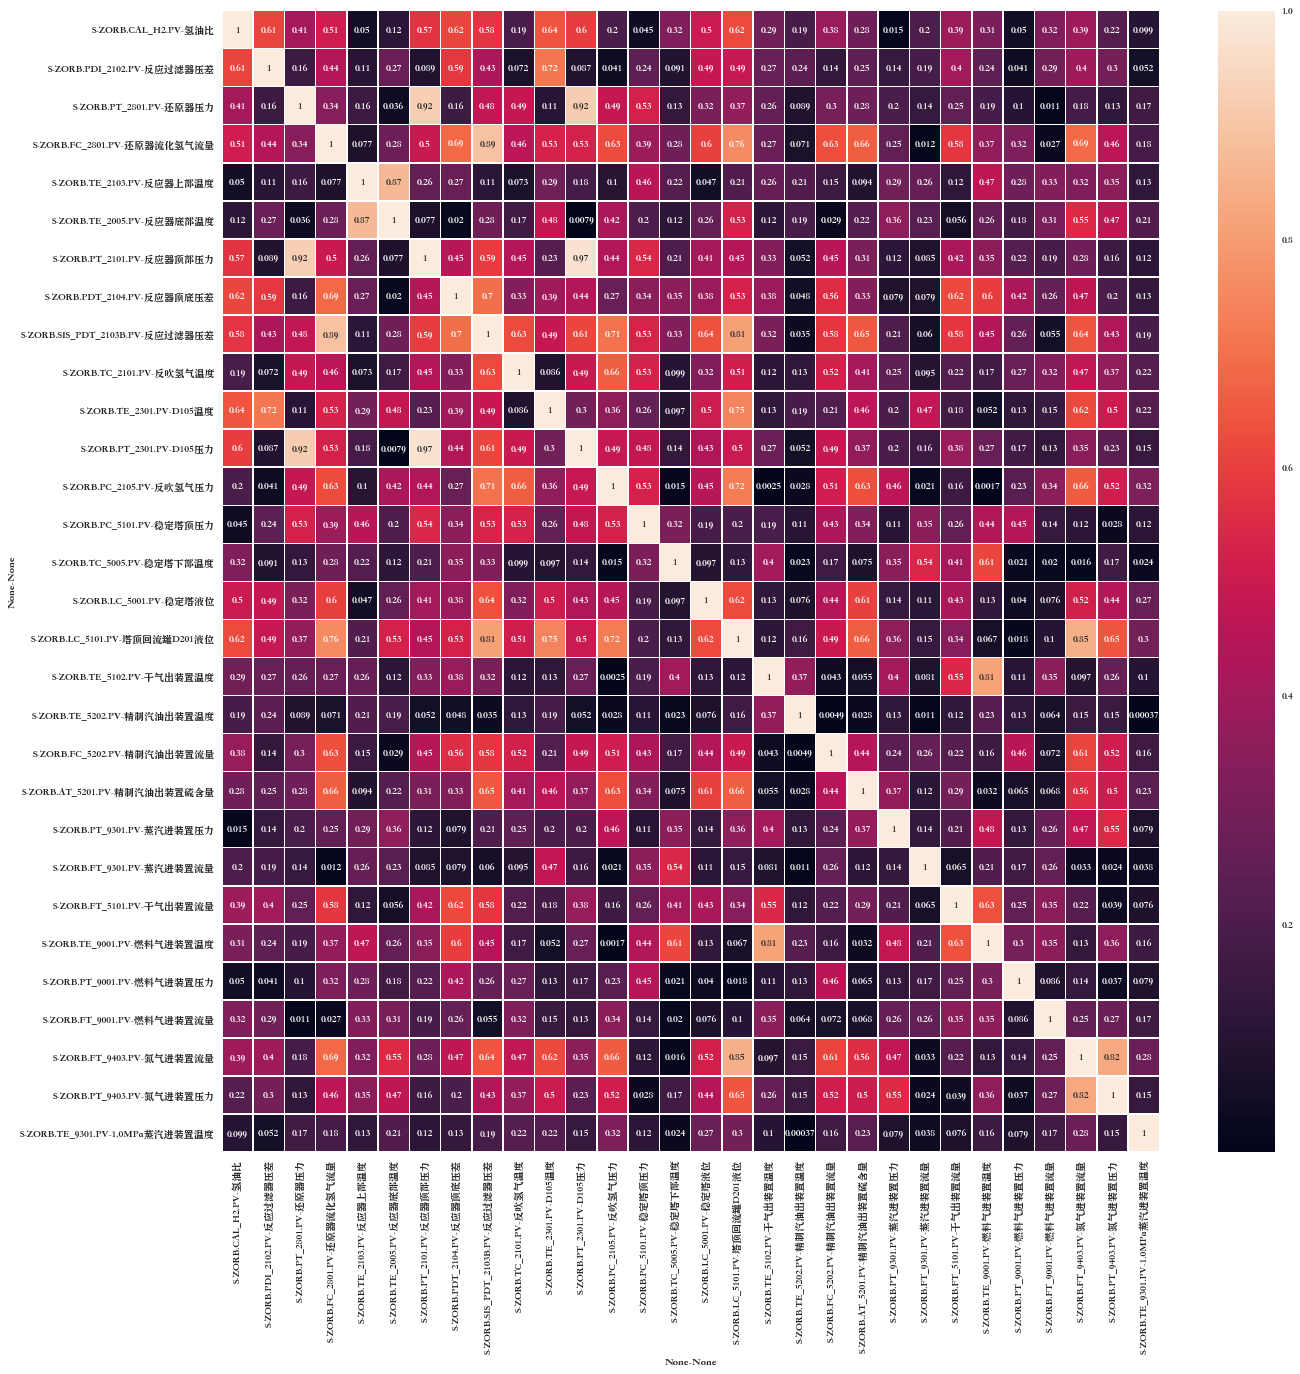

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

In [7]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.PT_2801.PV,S-ZORB.FC_2801.PV,S-ZORB.TE_2103.PV,S-ZORB.PDT_2104.PV,S-ZORB.TC_2101.PV,S-ZORB.TE_2301.PV,S-ZORB.PC_2105.PV,S-ZORB.PC_5101.PV,...,S-ZORB.TC_3102.DACA,S-ZORB.TE_1102.DACA,S-ZORB.AT-0001.DACA.PV,S-ZORB.AT-0008.DACA.PV,S-ZORB.AT-0012.DACA.PV,S-ZORB.FT_1204.DACA.PV,S-ZORB.CAL.LINE.PV,S-ZORB.FT_1503.DACA.PV,S-ZORB.FT_1504.DACA.PV,cluster
,氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度,反应器顶底压差,反吹氢气温度,D105温度,反吹氢气压力,稳定塔顶压力,...,E-105管程出口管,E-101壳程入口总管温度,S_ZORB AT-0001,S_ZORB AT-0008,S_ZORB AT-0012,D-121含硫污水排量,反应器线速,8.0MPa氢气至循环氢压缩机入口,8.0MPa氢气至反吹氢压缩机出口,
306,0.255545,19.515500,2.487665,848.474025,424.817923,58.194229,245.016200,325.197407,5.761861,0.650021,...,230.296873,426.452533,0.554783,0.699356,0.210781,56.699759,0.294451,2180.042900,2380.104400,1
305,0.275087,17.825372,2.486854,849.667293,420.961348,57.816495,245.035875,312.264713,5.792733,0.650008,...,229.748312,422.683515,0.553939,0.690159,0.211671,58.892811,0.285203,1644.659847,2408.988925,1
304,0.256952,17.797678,2.488842,900.762912,422.196638,60.390775,244.859542,292.703585,5.782618,0.650001,...,230.206335,423.952055,0.549776,0.695222,0.227906,46.054013,0.284243,1797.268175,2470.033225,1
303,0.263539,17.733658,2.503871,900.311315,428.246235,67.804545,244.924745,309.337023,5.774427,0.650066,...,229.875978,430.026372,0.551269,0.697762,0.217725,56.155798,0.283841,2690.828075,2261.629625,1
300,0.250815,19.631574,2.487546,899.186287,422.766277,64.255868,244.828352,318.698915,5.791275,0.650035,...,231.028437,423.795185,0.548218,0.709240,0.205886,60.137246,0.293511,2165.560648,2502.017900,1


In [8]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(97, 7)
(97, 3)
(97, 129)


In [9]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
re_dimension = int(manule_features.shape[1]/3)  # 需要调整的参数
relate_features = set()
max_iter = 60
num_iter = 0
tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
features_pool = list(set(manule_features.keys().to_numpy()))
choice_feature = random.choice(features_pool)

while len(relate_features) <= 30 and num_iter <= max_iter:
    X_tsne = tsne.fit_transform(manule_features[list(set(features_pool).difference(set(choice_feature)))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {X.shape[-1]}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    features_pool.remove(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 1 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 2 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 3 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 4 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 5 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 6 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 7 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 8 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 9 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 10 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 11 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 12 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 13 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 14 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 15 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 16 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 17 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 18 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 19 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 20 原始样本数据维度 129. t-SNE降维后的数据维度 43
num_iter => 21 原始样本数据维度 129. t-SNE降维后的数据维度 4

In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.SIS_PT_2602.PV,S-ZORB.PDC_2702.DACA,S-ZORB.TE_5008.DACA,S-ZORB.FT_1204.DACA.PV,S-ZORB.LC_1202.PV,S-ZORB.PDT_2604.PV,S-ZORB.PDT_2409.DACA,S-ZORB.FT_9401.PV,S-ZORB.BS_AT_2401.PV,S-ZORB.FC_2501.PV,...,S-ZORB.TE_7504.DACA,S-ZORB.PDT_2104.PV,S-ZORB.SIS_TE_6010.PV,S-ZORB.PT_2901.DACA,S-ZORB.TE_5004.DACA,S-ZORB.PC_3001.DACA,S-ZORB.PDT_3602.DACA,S-ZORB.PT_9301.PV,原料性质,时间
,再生器顶部/再生器接收器差压,再生器底部与再生接收器压差,E-205壳程出口管温度,D-121含硫污水排量,D121液面,再生器顶底差压,ME-115过滤器压差,净化风进装置流量,闭锁料斗烃含量,D107提升氮气流量,...,K-102A排气温度,反应器顶底压差,加热炉排烟出口温度,ME-103反吹气总管压力,稳定塔顶出口温度,D-113压力,冷氮气过滤器ME-114差压,蒸汽进装置压力,辛烷值RON,Unnamed: 1_level_1
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,...,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,9.700000e+01
mean,110.801419,28.318150,58.780751,48.565298,50.006668,38.173585,4.319266,112.591985,0.138787,43.249415,...,18.898455,76.121583,137.231894,541.341109,62.677854,0.050015,0.335253,0.836763,0.493483,1.532673e+18
std,21.659200,2.297069,5.949380,22.668838,0.069056,2.077943,3.222926,75.678969,0.251160,6.369092,...,2.692837,15.005374,9.810470,13.421738,5.776481,0.000127,0.101846,0.049372,0.696053,3.046478e+16
min,-100.000000,23.217911,44.216474,18.292067,49.894430,33.412400,-0.387378,36.078569,-0.100764,24.943916,...,7.537666,57.816495,106.449953,511.160055,48.037423,0.049907,0.117667,0.687334,-1.165168,1.496045e+18
25%,112.456765,26.627214,54.855644,33.988768,49.983108,36.532314,2.833493,103.890525,0.003879,41.453634,...,19.248780,62.268345,132.306160,531.292447,60.402352,0.049985,0.269154,0.812125,-0.030547,1.507536e+18
50%,112.833758,28.333698,59.821267,43.477219,49.998871,38.194217,3.989998,109.382993,0.134485,44.784596,...,19.248780,76.299772,136.878290,540.416353,63.803373,0.050001,0.318774,0.843666,0.536763,1.528445e+18
75%,113.340465,30.068837,62.403992,56.585160,50.016935,39.721335,5.375920,113.617796,0.179093,47.571668,...,19.248780,86.867542,140.935577,550.356670,66.650140,0.050014,0.372926,0.866333,0.990611,1.553846e+18
max,121.632583,33.311733,76.701491,196.901288,50.477479,42.528669,20.586924,830.662857,1.864136,51.568845,...,24.686882,107.489345,156.984453,585.591013,73.056547,0.051166,0.683846,0.953136,2.125231,1.590480e+18


In [12]:
weight_1st = manule_features.shape[0]/samples_features.shape[0]
model_features_1st = model_features
produc_features_1st = produc_features
%store model_features_1st
%store produc_features_1st
%store weight_1st

Stored 'model_features_1st' (DataFrame)
Stored 'produc_features_1st' (DataFrame)
Stored 'weight_1st' (float)
